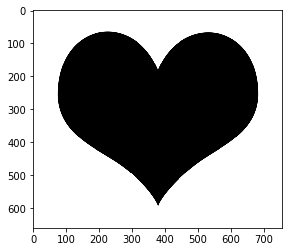

In [1]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random



import os
from scipy.io import loadmat

from torch.autograd import Variable
import torch

t = int(0)
random.seed(t)

from urllib.request import urlopen

heartshape_file = "http://www.teach.cs.toronto.edu/~csc411h/winter/valentine_viz/v.png"
heart = imread(urlopen(heartshape_file), mode="RGB")  
heart = imresize(heart, .3)
heart = sum(heart, 2).astype(float)
heart /= float(max(heart.flatten()))
imshow(heart, cmap = cm.gray)
figure(1)
show()

Now, let's generate the dataset:

In [2]:
def generate_imset(im, set_size):
    x1 = np.random.randint(0, im.shape[0]-1, set_size)
    x2 = np.random.randint(0, im.shape[1]-1, set_size)
    
    x = vstack((x2, x1)).T
    
    y_bool = (im[im.shape[0]-1-x1, x2] < .5)
    y1 = y_bool.astype(float)
    y2 = (1 - y_bool).astype(float)
    
    y = vstack((y1, y2)).T
    
    return x, y

In [3]:
train_size = 1250
test_size = 1000
train_set_x, train_set_y = generate_imset(heart, train_size)
test_set_x, test_set_y = generate_imset(heart, test_size)

figure(2)
scatter(train_set_x[train_set_y[:,0]==1.0,0], train_set_x[train_set_y[:,0]==1.0,1], color="r")
scatter(train_set_x[train_set_y[:,0]==0.0,0], train_set_x[train_set_y[:,0]==0.0,1], color="b")

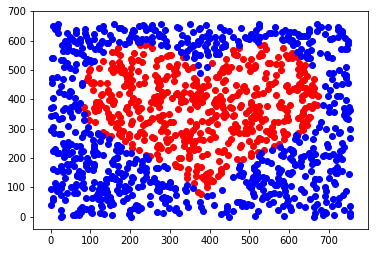

In [4]:
show()

We now have a dataset: the red points are 1's and the blue points are 0's. The inputs are just the coordinates.

A bit of housekeeping: let's write a function that returns minibatches:

In [5]:
def get_batch(set_x, set_y, N):
    idx = array(random.permutation(set_x.shape[0])[:N])
    batch_xs = set_x[idx, :]
    batch_ys = set_y[idx, :]
    
    return batch_xs, batch_ys

Now let's define our network

In [6]:
dim_x = 2
dim_h = 40
dim_out = 2


model = torch.nn.Sequential(
    torch.nn.Linear(dim_x, dim_h),
    torch.nn.ReLU(),
    torch.nn.Linear(dim_h, dim_out),
)

PyTorch's default initialization is very far away from what we want

In [7]:
model[0].weight.data = model[0].weight.data/10000.0
model[2].weight.data = model[2].weight.data/10000.0

More housekeeping:

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

heart_out = 0

Now let's train, while visualizing the prediction for each coordinate every T timesteps

In [9]:
T = 400

loss= Variable containing:
 0.6955
[torch.FloatTensor of size 1]

classification performance 0.581


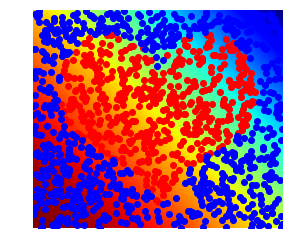

loss= Variable containing:
 0.4435
[torch.FloatTensor of size 1]

classification performance 0.797


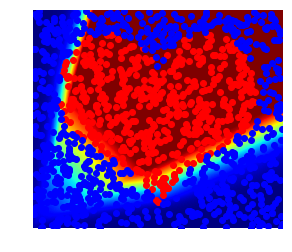

loss= Variable containing:
 0.4140
[torch.FloatTensor of size 1]

classification performance 0.794


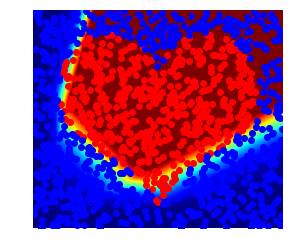

loss= Variable containing:
 0.3971
[torch.FloatTensor of size 1]

classification performance 0.803


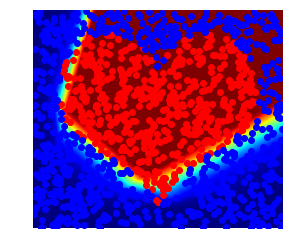

loss= Variable containing:
 0.3319
[torch.FloatTensor of size 1]

classification performance 0.835


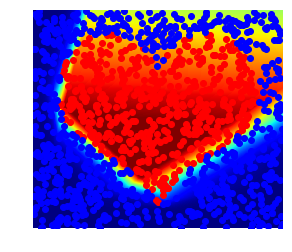

loss= Variable containing:
 0.2248
[torch.FloatTensor of size 1]

classification performance 0.94


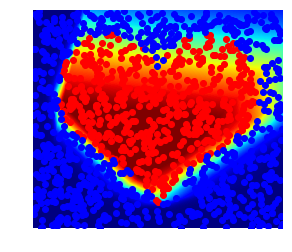

loss= Variable containing:
 0.1866
[torch.FloatTensor of size 1]

classification performance 0.946


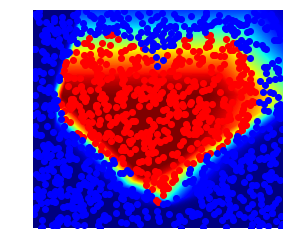

loss= Variable containing:
 0.1581
[torch.FloatTensor of size 1]

classification performance 0.955


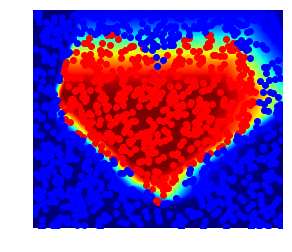

loss= Variable containing:
 0.1501
[torch.FloatTensor of size 1]

classification performance 0.962


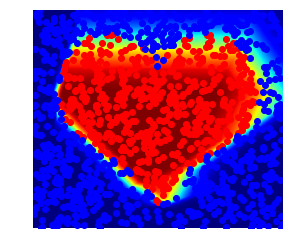

loss= Variable containing:
 0.1390
[torch.FloatTensor of size 1]

classification performance 0.952


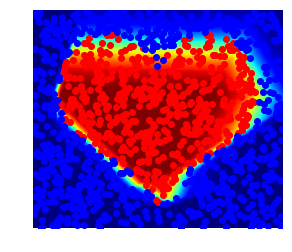

loss= Variable containing:
 0.1321
[torch.FloatTensor of size 1]

classification performance 0.951


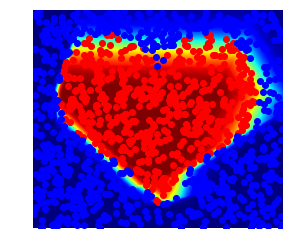

loss= Variable containing:
 0.1189
[torch.FloatTensor of size 1]

classification performance 0.966


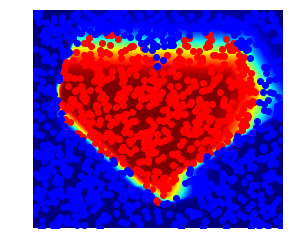

loss= Variable containing:
 0.1238
[torch.FloatTensor of size 1]

classification performance 0.949


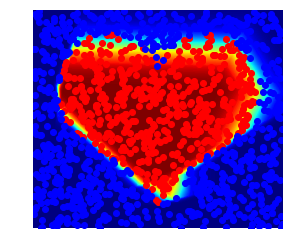

In [10]:
try:
    os.mkdir("new")
except:
    print("Warning: Folder named new not created")
    

for t in range(5000):
    batch_xs, batch_ys = get_batch(train_set_x, train_set_y, 1000)
    x = Variable(torch.from_numpy(batch_xs.astype(np.float32)))
    y_classes = Variable(torch.from_numpy(np.argmax(batch_ys, 1)))

    y_pred = model(x)
    loss = loss_fn(y_pred, y_classes)
    model.zero_grad()  
    loss.backward()    
    optimizer.step()   
    
    
    if t % T == 0:
        
        class_performance = np.mean( (y_pred[:,1].data.numpy()>0) == y_classes.data.numpy())
        print("loss=", loss)
        print("classification performance", class_performance)
        
        x1, x2 = np.meshgrid(np.arange(0, heart.shape[0]).astype(np.float32), np.arange(0,heart.shape[1]).astype(np.float32))
        
        all_x =  Variable(torch.from_numpy(vstack((x2.flatten(), x1.flatten())).T))
        all_y = torch.nn.Softmax()(model(all_x))
        
        
        all_y0 = all_y[:, 0].data.numpy()
        all_y0 = all_y0.reshape((heart.shape[1], heart.shape[0])).T
    
        fig = figure(heart_out)
        axis("off")
        
        scatter(train_set_x[train_set_y[:,0]==1.0,0], train_set_x[train_set_y[:,0]==1.0,1], color="r")
        scatter(train_set_x[train_set_y[:,0]==0.0,0], train_set_x[train_set_y[:,0]==0.0,1], color="b")

        imshow(all_y0, origin="lower", cmap = plt.cm.jet)
        
  
        fig.savefig("new/im%.4d.png" % heart_out)
        plt.show()
        
        
        heart_out += 1
  